In [1]:
!git clone https://github.com/vladislareon/Sparse_vector

Cloning into 'Sparse_vector'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), 3.92 KiB | 1.96 MiB/s, done.


In [2]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
from Sparse_vector.sparse_vector import SparseVector

In [3]:
!git clone https://github.com/vladislareon/z_dna

Cloning into 'z_dna'...
remote: Enumerating objects: 2052, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 2052 (delta 8), reused 0 (delta 0), pack-reused 2021
Receiving objects: 100% (2052/2052), 1.75 GiB | 33.30 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (2024/2024), done.


In [4]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features]

def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [5]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}
# ZDNA_shin = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
# ZDNA_cousine = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

# ZDNABERT.pkl, Kouzine_hg38.pkl, EndoQuad_hg19.pkl

ZDNA_data = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')

DNA_features = {feture: load(f'z_dna/hg38_features/sparse/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 2min 36s, sys: 6.68 s, total: 2min 43s
Wall time: 2min 42s


In [6]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
class Dataset(data.Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels_source, intervals, lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.lrp_feat = lrp_feat
        
    def __len__(self):
        return len(self.intervals)
    
    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(self.lrp_feat)]
        
        return (X, y)
        
        

In [7]:
width =1000

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chroms:
    for st in trange(0, ZDNA_data[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA_data[chrm].shape)]
        if ZDNA_data[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████| 16/16 [00:00<00:00, 15820.10it/s]


In [8]:
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

In [9]:
train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem 
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]



train_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA_data, train_intervals, lrp_feat = [])

test_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA_data, test_intervals, lrp_feat = [])

In [10]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from IPython.display import clear_output
class ImageZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),
                    nn.Conv2d(3, 2, kernel_size=(5, 5), padding=2),
                    nn.BatchNorm2d(2),
                    nn.ReLU(),
                    nn.Conv2d(2, 1, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(1950, 1000),
                    nn.Dropout(0.5),
                    nn.ReLU(),
                    nn.Linear(1000, 800),
                    nn.Dropout(0.2),
                    nn.ReLU(),
                    nn.Linear(800, 2)
        )
    
    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1950)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [13]:
import tqdm
from sklearn.utils.class_weight import compute_class_weight
from copy import deepcopy

params = {'batch_size':64,
          'num_workers':2,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)


def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)

def train_epoch(model, optimizer):
    loss_log, acc_log, roc_auc_log, f1_log, pr_log = [], [], [], [], []
    model.train()
    for _, (X_batch, y_batch) in enumerate(tqdm.tqdm(loader_train)):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten()
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            pr = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
            pr = average_precision_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        pr_log.append(pr)

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log, pr_log

def test(model):
    loss_log, acc_log, roc_auc_log, f1_log, pr_log = [], [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in loader_test:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        pred = torch.argmax(output, dim=2)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            pr = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
            pr = average_precision_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))
        pr_log.append(pr)
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log, pr_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=8):
    plt.figure(figsize=(epoch_to_show, 5))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='grey', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='magenta', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log, train_auc_log, train_f1_log, train_pr_log = [], [], [], [], []
    val_log,   val_acc_log,   val_auc_log, val_f1_log, val_pr_log  = [], [], [], [], []
    f1_max = 0
    best_model = None
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_loss, train_acc, train_auc, train_f1, train_pr = train_epoch(model, opt)
        val_loss, val_acc, val_auc, val_f1, val_pr = test(model)
        
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)
        train_pr_log.extend(train_pr)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        val_pr_log.append(np.mean(val_pr))
        clear_output()
        if (epoch % 1) == 0:
            if (val_f1_log[-1] > f1_max) and (val_f1_log[-1] > 0.65):
                best_model = deepcopy(model)
                f1_max = val_f1_log[-1]
                torch.save(best_model.state_dict(), f'Epoch={epoch+1}, F1={val_f1_log[-1]}.pt')
                print('-' * 10)
                print(f'Epoch={epoch+1}, F1={val_f1_log[-1]}.pt')
                print('-' * 10)
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'AUC-ROC',      BatchSize)
          #  plot_history(train_pr_log, val_pr_log,   'AUC-PR',       BatchSize)
            plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
            
            
            print("Epoch {} AUC-ROC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            print("Epoch {} Accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            print("Epoch {} F1-score = {:.2%}".format(epoch+1, val_f1_log[-1]))
            display(pd.DataFrame({'epoch': np.arange(epoch + 1) + 1, 'AUC-ROC':val_auc_log,
                                'F1-score':val_f1_log  }))


            
            
    print("Final AUC: {:.2}".format(val_auc_log[-1]))
    print("Final accuracy: {:.2}".format(val_acc_log[-1]))
    print("Final F1-score: {:.2}".format(val_f1_log[-1]))
  #  print("Final Pr: {:.2}".format(val_pr_log[-1]))
    return best_model

In [14]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [15]:
model = ImageZ()
model= nn.DataParallel(model)
model = model.cuda()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 2753615


In [16]:
import gc
# del model

gc.collect()

torch.cuda.empty_cache()

In [17]:
!nvidia-smi

Wed Jun 26 17:37:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              27W /  70W |    125MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

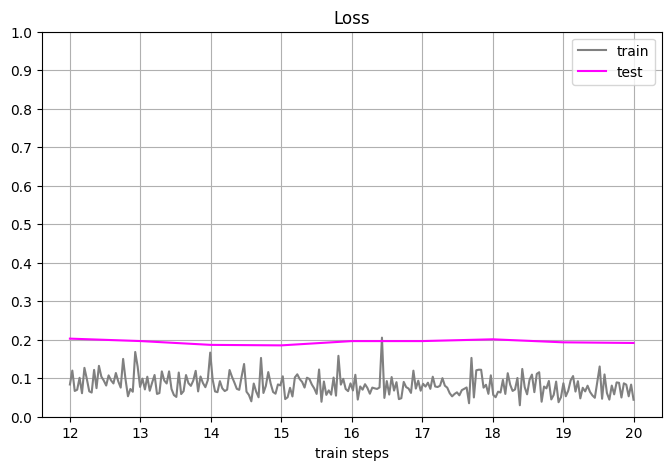

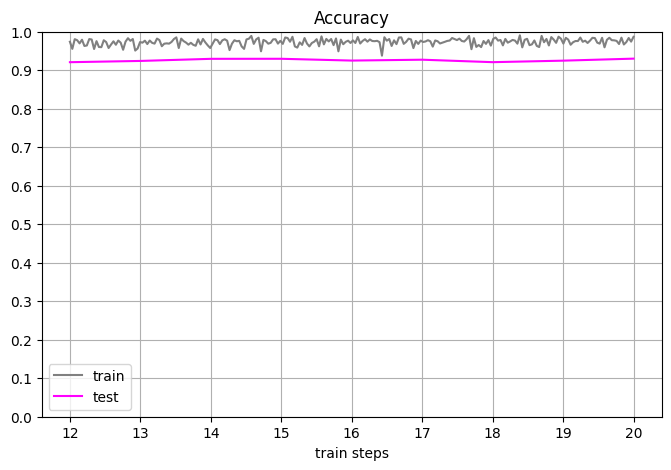

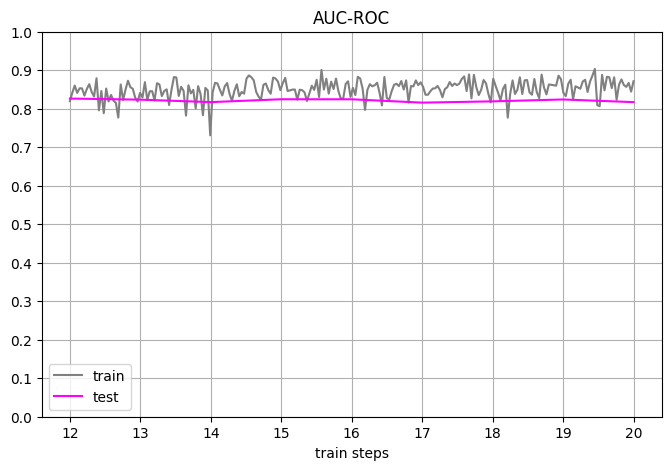

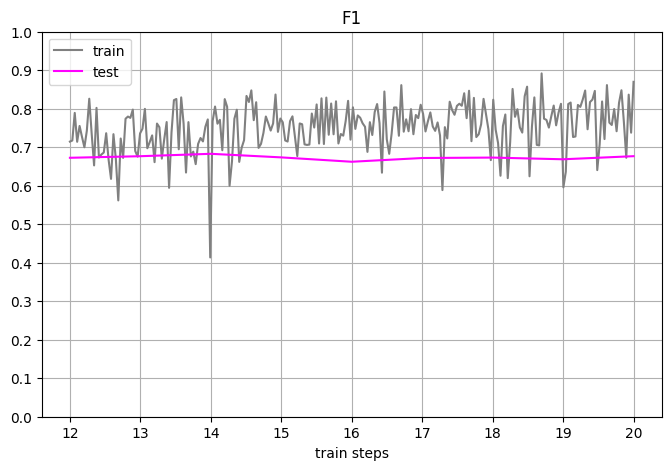

Epoch 20 AUC-ROC = 81.71%
Epoch 20 Accuracy = 93.01%
Epoch 20 F1-score = 67.67%


,epoch,AUC-ROC,F1-score
0,1,0.748978,0.207324
1,2,0.790380,0.220792
2,3,0.769608,0.543862
3,4,0.789666,0.571818
4,5,0.800238,0.592791
5,6,0.814351,0.620615
6,7,0.810351,0.628487
7,8,0.827080,0.654873
8,9,0.819321,0.644534
9,10,0.819760,0.664847


Final AUC: 0.82
Final accuracy: 0.93
Final F1-score: 0.68


In [61]:
torch.cuda.empty_cache()
torch.manual_seed(1303)
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
best_model = train(model, opt, 20)

In [64]:
# torch.save(model.state_dict(), 'hg38.pt')